<a href="https://colab.research.google.com/github/hardik1408/CS771/blob/hardik/emoticon_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the files

In [45]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load the CSV files
train_df = pd.read_csv('mini-project-1/datasets/train/train_emoticon.csv')
validation_df = pd.read_csv('mini-project-1/datasets/valid/valid_emoticon.csv')
test_df = pd.read_csv('mini-project-1/datasets/test/test_emoticon.csv')

# Assuming the CSV files have 'emojis' and 'label' columns
train_texts = train_df['input_emoticon'].values
train_labels = train_df['label'].values

validation_texts = validation_df['input_emoticon'].values
validation_labels = validation_df['label'].values

test_texts = test_df['input_emoticon'].values


# Data Observation

Checking how the data is made up, its distribution, frequencies etc.

1) How many unique emoticons? ----- (214)
2) We observe - 7 emoticons occur in every string, making 10/13 of the string.
3) Only 3 emoticons, other than the 7 discussed, are present in each string.
 

In [46]:
total_train = [] # A list of all the emoticons
for i in train_texts:
    total_train += i

emoji_freq = dict() # Each emoticon mapped to its frequency of occurence
for i in total_train:
    if i in emoji_freq:
        emoji_freq[i] += 1
    else:
        emoji_freq[i] = 1

print('Total unique emoticons: ', len(emoji_freq))

Total unique emoticons:  214


In [47]:
emoji_0_1 = dict()

for i in emoji_freq:
    emoji_0_1[i] = (0,0)

for i in emoji_freq:
    for j in range(len(train_texts)):
        if i in train_texts[j]:
            if train_labels[j] == 1:
                emoji_0_1[i] = (emoji_0_1[i][0], emoji_0_1[i][1]+1)
            else:
                emoji_0_1[i] = (emoji_0_1[i][0]+1, emoji_0_1[i][1])

emoji_0_1

{'😛': (3576, 3504),
 '🛐': (3576, 3504),
 '😻': (81, 82),
 '😑': (3576, 3504),
 '😣': (3576, 3504),
 '🙠': (19, 44),
 '🙯': (3576, 3504),
 '🚼': (3576, 3504),
 '😒': (83, 82),
 '🙼': (3576, 3504),
 '😪': (80, 83),
 '🚅': (34, 34),
 '😹': (81, 79),
 '🚡': (82, 80),
 '🙲': (39, 33),
 '🛑': (80, 83),
 '🙐': (79, 77),
 '🙪': (31, 19),
 '🛆': (84, 84),
 '🚟': (76, 79),
 '🙋': (27, 18),
 '🚧': (35, 37),
 '🚜': (79, 85),
 '🙕': (81, 80),
 '🚥': (29, 23),
 '😬': (82, 81),
 '🚄': (79, 76),
 '🚔': (27, 34),
 '🛓': (83, 76),
 '\U0001f6dc': (32, 23),
 '😚': (81, 76),
 '🚠': (85, 81),
 '🙷': (22, 30),
 '😍': (81, 82),
 '😿': (80, 81),
 '🙚': (25, 24),
 '😸': (79, 79),
 '😯': (38, 42),
 '🙒': (84, 79),
 '🚙': (31, 24),
 '🚴': (32, 35),
 '😴': (81, 80),
 '🚂': (36, 30),
 '😦': (78, 82),
 '🙨': (83, 82),
 '🛝': (36, 25),
 '😉': (84, 79),
 '😵': (26, 20),
 '🚃': (83, 79),
 '😘': (28, 22),
 '😊': (84, 78),
 '😌': (34, 34),
 '🙧': (41, 29),
 '🚍': (82, 77),
 '😢': (83, 82),
 '🚵': (34, 23),
 '😩': (85, 82),
 '😠': (27, 30),
 '🛡': (78, 81),
 '😰': (27, 22),
 '🚏

In [48]:

most_frequent_emojis = []
for i in emoji_0_1:
    if emoji_0_1[i] == (3576, 3504):
        most_frequent_emojis.append(i)

most_frequent_emojis

['😛', '🛐', '😑', '😣', '🙯', '🚼', '🙼']

We find that in every row these 7 emoticons appear!

Also, these 7 emoticons make up exactly 10/13 of every given string (Be it train or validation)

So, we make modified datasets ie. 'train_texts_mod', 'validation_texts_mod', and 'test_texts_mod', which omit the 7 most 
occuring emoticons. So all these 3 modified lists have 3 length string elements.

### Modifying the datasets

In [49]:
train_texts_mod = []

for i in train_texts:
    s = ''
    for j in i:
        if j not in most_frequent_emojis:
            s += j
    train_texts_mod.append(s)

train_texts_mod = np.array(train_texts_mod, dtype=object)

In [50]:
validation_texts_mod = []

for i in validation_texts:
    s = ''
    for j in i:
        if j not in most_frequent_emojis:
            s += j
    validation_texts_mod.append(s)

validation_texts_mod = np.array(validation_texts_mod, dtype=object)

In [51]:
test_texts_mod = []

for i in test_texts:
    s = ''
    for j in i:
        if j not in most_frequent_emojis:
            s += j
    test_texts_mod.append(s)

test_texts_mod = np.array(test_texts_mod, dtype=object)

# Preprocessing on input

In [52]:
#  Tokenize and pad the emoji sequences
tokenizer = Tokenizer(char_level=True)  # Tokenizing each emoji as a character
tokenizer.fit_on_texts(train_texts)  # Fit only on training data

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts_mod)
validation_sequences = tokenizer.texts_to_sequences(validation_texts_mod)
test_sequences = tokenizer.texts_to_sequences(test_texts_mod)

# Pad the sequences to the same length
max_len = max([len(seq) for seq in train_sequences])  # Maximum sequence length in train data
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
validation_padded = pad_sequences(validation_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

# Convert labels into numeric format if they are not (if necessary)
train_labels = train_labels.astype(int)
validation_labels = validation_labels.astype(int)

### Dividing data for the task

In [53]:
x_train_100 = train_padded
y_train_100 = train_labels
# prompt: take only 80% of the training dataset

train_size_80 = int(len(x_train_100) * 0.8)
x_train_80 = x_train_100[:train_size_80]
y_train_80 = y_train_100[:train_size_80]
# prompt: take only 60% of training data

# Shuffle the indices of the training data
indices = np.arange(len(x_train_100))
np.random.shuffle(indices)

# Calculate the number of samples for 60% of the data
train_size_60_random = int(len(x_train_100) * 0.6)

# Select the shuffled indices for the 60% split
x_train_60 = x_train_100[indices[:train_size_60_random]]
y_train_60 = y_train_100[indices[:train_size_60_random]]

indices = np.arange(len(x_train_100))
np.random.shuffle(indices)

# Calculate the number of samples for 60% of the data
train_size_40_random = int(len(x_train_100) * 0.4)

# Select the shuffled indices for the 60% split
x_train_40 = x_train_100[indices[:train_size_40_random]]
y_train_40 = y_train_100[indices[:train_size_40_random]]

indices = np.arange(len(x_train_100))
np.random.shuffle(indices)

# Calculate the number of samples for 60% of the data
train_size_20_random = int(len(x_train_100) * 0.2)

# Select the shuffled indices for the 60% split
x_train_20 = x_train_100[indices[:train_size_20_random]]
y_train_20 = y_train_100[indices[:train_size_20_random]]



# Model


In [64]:
%timeit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Define the improved LSTM model
model = Sequential()

# Embedding layer: increases embedding dimension size for richer representation
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8, input_length=max_len))

# First LSTM layer: Bidirectional LSTM for capturing dependencies in both directions
model.add(Bidirectional(LSTM(8, return_sequences=True)))  # Return sequences for stacking another LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer: another Bidirectional LSTM layer for deeper sequential learning
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.2))  # Another dropout layer

# Batch Normalization: helps with stabilizing and accelerating training
model.add(BatchNormalization())

# Dense Layer: fully connected layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Output Layer: Sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and learning rate adjustment
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Training with 100% data

In [65]:
model.fit(x_train_100, y_train_100, epochs=25, batch_size=32, validation_data=(validation_padded, validation_labels))
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_padded, validation_labels)

acc_100 = accuracy

# Print the final accuracy
print(f'Validation Accuracy: {accuracy:.4f}')

model.save('emoticons_model.keras')

Epoch 1/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5233 - loss: 0.6898 - val_accuracy: 0.8057 - val_loss: 0.6259
Epoch 2/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8308 - loss: 0.3871 - val_accuracy: 0.8957 - val_loss: 0.3405
Epoch 3/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8895 - loss: 0.2738 - val_accuracy: 0.8793 - val_loss: 0.2407
Epoch 4/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8839 - loss: 0.2589 - val_accuracy: 0.9305 - val_loss: 0.1605
Epoch 5/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8920 - loss: 0.2469 - val_accuracy: 0.9571 - val_loss: 0.1249
Epoch 6/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9049 - loss: 0.2179 - val_accuracy: 0.9468 - val_loss: 0.1285
Epoch 7/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9094 - loss: 0.2121 - val_accuracy: 0.9530 - val_loss: 0.1106
Epoch 8/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9214 - loss: 0.1831 - val_accuracy: 0.

In [13]:
# Print the model summary for reference
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 3, 8)           │         1,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 3, 16)          │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,173 (86.62 KB)

 Trainable params: 7,369 (28.79 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 14,740 (57.58 KB)

### Training with 80% data

In [14]:
%timeit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Define the improved LSTM model
model = Sequential()

# Embedding layer: increases embedding dimension size for richer representation
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8, input_length=max_len))

# First LSTM layer: Bidirectional LSTM for capturing dependencies in both directions
model.add(Bidirectional(LSTM(8, return_sequences=True)))  # Return sequences for stacking another LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer: another Bidirectional LSTM layer for deeper sequential learning
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.2))  # Another dropout layer

# Batch Normalization: helps with stabilizing and accelerating training
model.add(BatchNormalization())

# Dense Layer: fully connected layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Output Layer: Sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and learning rate adjustment
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(x_train_80, y_train_80, epochs=25, batch_size=32, validation_data=(validation_padded, validation_labels))
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_padded, validation_labels)

acc_80 = accuracy

# Print the final accuracy
print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 0.6886 - val_accuracy: 0.6094 - val_loss: 0.6730
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8064 - loss: 0.4427 - val_accuracy: 0.8712 - val_loss: 0.4093
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8809 - loss: 0.2826 - val_accuracy: 0.9141 - val_loss: 0.2563
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9081 - loss: 0.2318 - val_accuracy: 0.9264 - val_loss: 0.1768
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9074 - loss: 0.2329 - val_accuracy: 0.9305 - val_loss: 0.1498
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9290 - loss: 0.1766 - val_accuracy: 0.9448 - val_loss: 0.1308
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9262 - loss: 0.1683 - val_accuracy: 0.9509 - val_loss: 0.1036
Epoch 8/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - loss: 0.1702 - val_accuracy: 0.

### Training with 60% data

In [16]:
%timeit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Define the improved LSTM model
model = Sequential()

# Embedding layer: increases embedding dimension size for richer representation
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8, input_length=max_len))

# First LSTM layer: Bidirectional LSTM for capturing dependencies in both directions
model.add(Bidirectional(LSTM(8, return_sequences=True)))  # Return sequences for stacking another LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer: another Bidirectional LSTM layer for deeper sequential learning
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.2))  # Another dropout layer

# Batch Normalization: helps with stabilizing and accelerating training
model.add(BatchNormalization())

# Dense Layer: fully connected layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Output Layer: Sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and learning rate adjustment
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(x_train_60, y_train_60, epochs=25, batch_size=32, validation_data=(validation_padded, validation_labels))
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_padded, validation_labels)

acc_60 = accuracy

# Print the final accuracy
print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4976 - loss: 0.6947 - val_accuracy: 0.5153 - val_loss: 0.6918
Epoch 2/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6351 - loss: 0.6444 - val_accuracy: 0.8180 - val_loss: 0.5630
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3417 - val_accuracy: 0.9039 - val_loss: 0.3907
Epoch 4/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8823 - loss: 0.2793 - val_accuracy: 0.8916 - val_loss: 0.2882
Epoch 5/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9025 - loss: 0.2467 - val_accuracy: 0.9223 - val_loss: 0.1947
Epoch 6/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9039 - loss: 0.2456 - val_accuracy: 0.9284 - val_loss: 0.1633
Epoch 7/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9065 - loss: 0.2185 - val_accuracy: 0.9202 - val_loss: 0.1670
Epoch 8/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9135 - loss: 0.2241 - val_accuracy: 0.

### Training with 40% data

In [18]:
%timeit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Define the improved LSTM model
model = Sequential()

# Embedding layer: increases embedding dimension size for richer representation
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8, input_length=max_len))

# First LSTM layer: Bidirectional LSTM for capturing dependencies in both directions
model.add(Bidirectional(LSTM(8, return_sequences=True)))  # Return sequences for stacking another LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer: another Bidirectional LSTM layer for deeper sequential learning
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.2))  # Another dropout layer

# Batch Normalization: helps with stabilizing and accelerating training
model.add(BatchNormalization())

# Dense Layer: fully connected layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Output Layer: Sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and learning rate adjustment
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x_train_40, y_train_40, epochs=25, batch_size=32, validation_data=(validation_padded, validation_labels))
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_padded, validation_labels)

acc_40 = accuracy

# Print the final accuracy
print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5001 - loss: 0.6936 - val_accuracy: 0.5562 - val_loss: 0.6929
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5482 - loss: 0.6853 - val_accuracy: 0.6033 - val_loss: 0.6863
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7100 - loss: 0.5886 - val_accuracy: 0.8241 - val_loss: 0.5424
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.3400 - val_accuracy: 0.8691 - val_loss: 0.4436
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8969 - loss: 0.2736 - val_accuracy: 0.8650 - val_loss: 0.3574
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8962 - loss: 0.2505 - val_accuracy: 0.8691 - val_loss: 0.2852
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8909 - loss: 0.2631 - val_accuracy: 0.8978 - val_loss: 0.2398
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9180 - loss: 0.2064 - val_accuracy: 0.9100 - val_loss:

### Training with 20% data

In [20]:
%timeit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Define the improved LSTM model
model = Sequential()

# Embedding layer: increases embedding dimension size for richer representation
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8, input_length=max_len))

# First LSTM layer: Bidirectional LSTM for capturing dependencies in both directions
model.add(Bidirectional(LSTM(8, return_sequences=True)))  # Return sequences for stacking another LSTM layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer: another Bidirectional LSTM layer for deeper sequential learning
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.2))  # Another dropout layer

# Batch Normalization: helps with stabilizing and accelerating training
model.add(BatchNormalization())

# Dense Layer: fully connected layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Output Layer: Sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and learning rate adjustment
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(x_train_20, y_train_20, epochs=25, batch_size=32, validation_data=(validation_padded, validation_labels))
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_padded, validation_labels)

acc_20 = accuracy

# Print the final accuracy
print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5236 - loss: 0.6938 - val_accuracy: 0.5153 - val_loss: 0.6929
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5481 - loss: 0.6846 - val_accuracy: 0.5153 - val_loss: 0.6925
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5932 - loss: 0.6760 - val_accuracy: 0.5112 - val_loss: 0.6907
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7051 - loss: 0.6113 - val_accuracy: 0.6299 - val_loss: 0.6774
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7558 - loss: 0.5173 - val_accuracy: 0.6810 - val_loss: 0.6293
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3652 - val_accuracy: 0.8016 - val_loss: 0.5451
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3276 - val_accuracy: 0.8344 - val_loss: 0.4887
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8797 - loss: 0.2870 - val_accuracy: 0.8160 - val_loss:

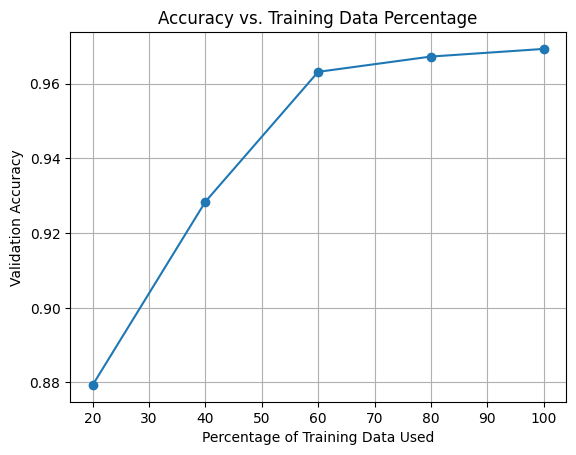

In [22]:
# prompt: create a plot which plots the accuracy vs the percentage of training data used

import matplotlib.pyplot as plt

# Assuming you have the accuracy values for each training data percentage stored in a list
training_data_percentages = [20, 40, 60, 80, 100]
accuracies = [acc_20, acc_40, acc_60, acc_80, acc_100]  # Replace with your actual accuracy values


# Create the plot
plt.plot(training_data_percentages, accuracies, marker='o')
plt.xlabel('Percentage of Training Data Used')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs. Training Data Percentage')
plt.grid(True)
plt.show()


# Test Data Predictions

In [30]:
# Load the CSV files
test_df = pd.read_csv('/Users/namangupta/Desktop/771/mini-project-1/datasets/test/test_emoticon.csv')

# Assuming the CSV files have 'emojis' and 'label' columns
test_texts = test_df['input_emoticon'].values


Again, all the test data strings are of length 3, after preprocessing. So, they can be fed into our already trained model to get the binary prediction labels.

In [42]:
predictions = model.predict(test_padded)
predicted_labels = (predictions > 0.5).astype(int)

predictions_string = ''
for i in predicted_labels:
    predictions_string += str(i[0])

predictions_string


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


'001000011111001000010100001100010101010101101111001000000010010100000000011011100010001000111010111001011011110110010010011100101111111001001000001000001110010100001101100011000001101000101000110011000111101001000001100100100000001010000110000111000001000001001110101100101011110011110011110001011101001100000001000000011000111000011110111000100101100000110000100011001100101100100100010011111001100101010000101100111000001000000001010001100010100100111101100001000101010000000001110001001100110011001011010010000000011001001010101110000100110101101010010100011100000101000010100000011101011000100010000011010010001110011110100000101100010000110001010110100010011111100001010010101100000010000010000100000101000000100011110000001001010000111100110010001101011011010001111110000100001000000000001011100011010110001001010010101001000000001110010001100000100101100001011000100000000100101010101011100100111100010000101100001111010110000110001010000011001011001011000010000001011011011000101110010100011